In [11]:
import numpy as np
import mrcfile
import matplotlib.pyplot as plt

In [12]:
test_file = "/home/mwh1998/fsl_groups/grp_tomo_db1_d3/compute/TomoDB1_d3/Hneptunium_secretin/aba2006-11-01-6/Hyphomonas_10bin_full.rec"
data = None
with mrcfile.open(test_file) as mrc:
    data = mrc.data.copy()

In [13]:
data.shape

(390, 1024, 1024)

In [14]:
height = data.shape[0]
margin = int(height * .2)
cropped = data[margin:(height-margin), :, :]

In [15]:
cropped_shape = cropped.shape
print(cropped_shape)

(234, 1024, 1024)


In [16]:
selected_slice_idx = np.random.randint(0, cropped_shape[0]-5)
selected_slice = cropped[selected_slice_idx:selected_slice_idx + 5, :, :].mean(0)

-330.2
1520.2


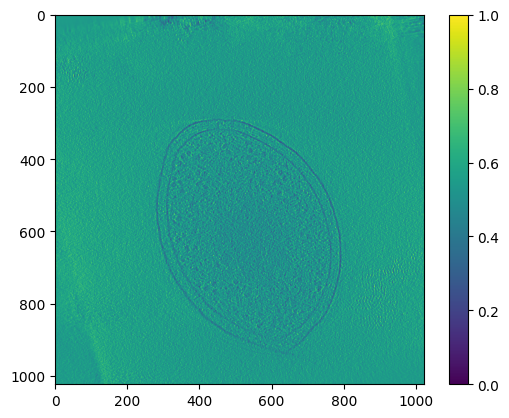

In [17]:
print(selected_slice.min())
print(selected_slice.max())

rescaled = (selected_slice - selected_slice.min()) / (selected_slice.max() - selected_slice.min())

plt.imshow(rescaled)
plt.xticks(None)
plt.colorbar()
plt.show()

In [18]:
bacteria = rescaled[275:950,275:800]
not_bacteria = rescaled[0:275, 0:275]

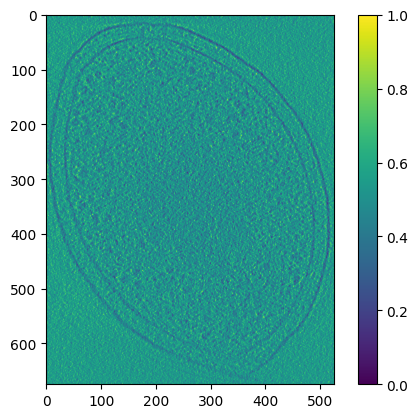

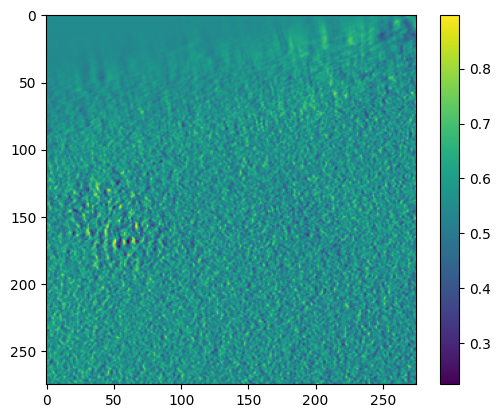

In [19]:
plt.imshow(bacteria)
plt.colorbar()
plt.show()

plt.imshow(not_bacteria)
plt.colorbar()
plt.show()

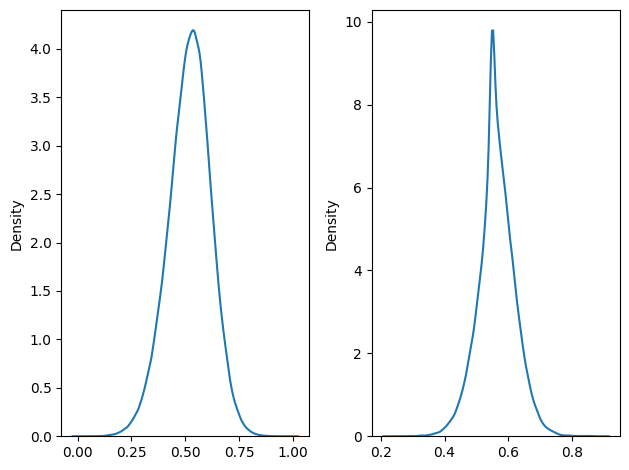

In [20]:
import seaborn as sns

fig, ax = plt.subplots(1,2)

sns.kdeplot(bacteria.flatten(), ax=ax[0])
sns.kdeplot(not_bacteria.flatten(), ax=ax[1])
plt.tight_layout()
plt.show()

In [21]:
bacteria.mean()

0.5192700020053816

In [22]:
not_bacteria.mean()

0.5633710018472665

In [23]:
rescaled.mean()

0.5471145283129638

In [25]:
def apply_contrast(factor):
    mean = np.mean(bacteria, axis=(0,1), keepdims=True)
    image_contrast = mean + factor * (bacteria - mean)
    image_contrast = np.clip(image_contrast, 0.0, 1.0)
    return image_contrast

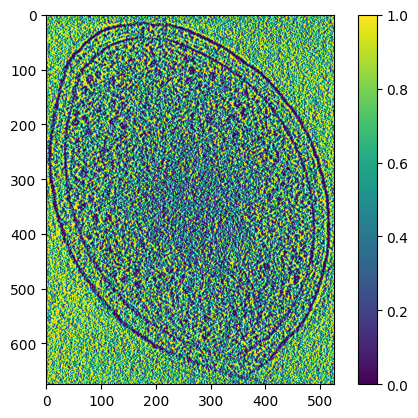

In [26]:
plt.imshow(apply_contrast(10))
plt.colorbar()
plt.show()

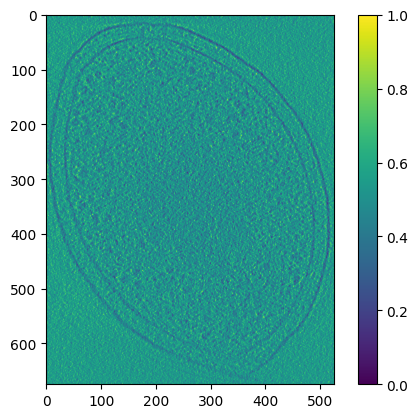

In [27]:
plt.imshow(apply_contrast(1))
plt.colorbar()
plt.show()

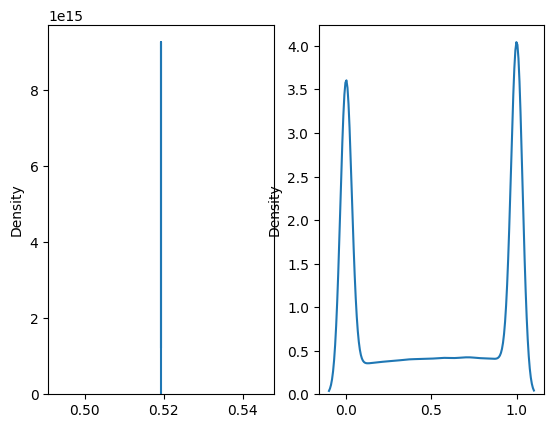

In [28]:
no_contrast = apply_contrast(0)
ten_contrast = apply_contrast(10)

fig, axes = plt.subplots(1,2)
sns.kdeplot(no_contrast.flatten(), ax=axes[0])
sns.kdeplot(ten_contrast.flatten(), ax=axes[1])
plt.show()

In [29]:
ten_contrast.shape

(675, 525)

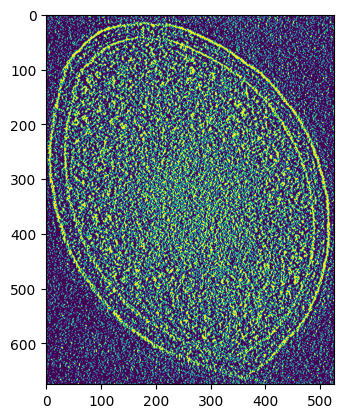

In [30]:
mask = ten_contrast < .1

zeros_like = np.zeros_like(ten_contrast)
zeros_like[mask] = 1

plt.imshow(zeros_like)
plt.show()


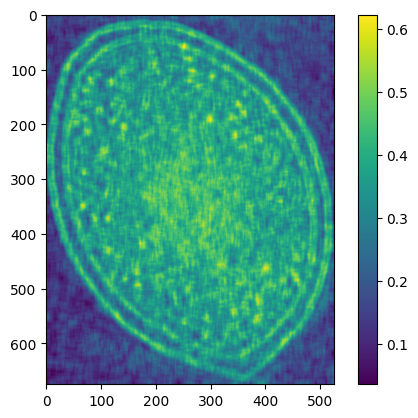

In [31]:
import cv2

initial_detection = zeros_like.copy()

blurred_image = cv2.blur(initial_detection,(15,15))

plt.imshow(blurred_image)
plt.colorbar()
plt.show()


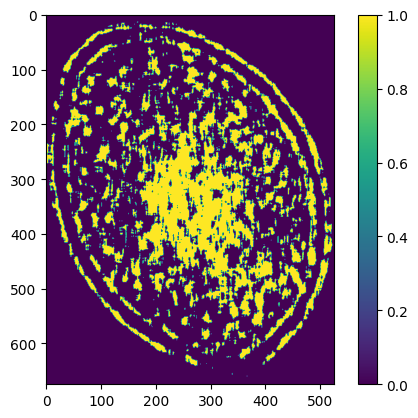

In [32]:
thresholded_pixels = blurred_image > np.percentile(blurred_image, 75)

mask = np.zeros_like(blurred_image)
mask[thresholded_pixels] = 1

plt.imshow(mask)
plt.colorbar()
plt.show()

In [33]:
from sklearn.cluster import DBSCAN
locations = np.where(mask == 1)

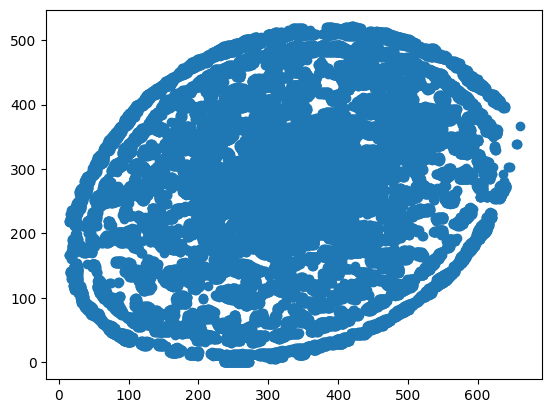

In [34]:
plt.scatter(locations[0], locations[1])
plt.show()

In [35]:
points = np.asarray(list(zip(locations[0], locations[1])))
print(len(points))

85944


In [36]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=5)

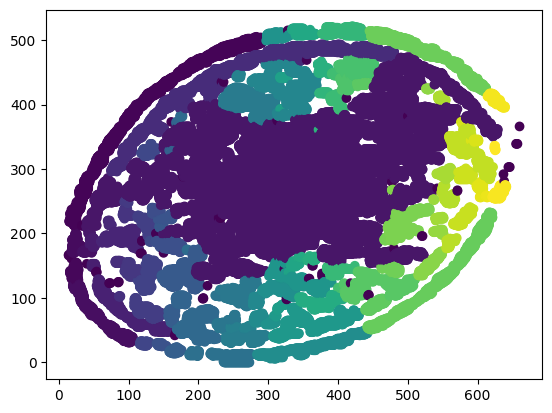

In [37]:
labels = dbscan.fit_predict(points)
plt.scatter(locations[0], locations[1], c=labels)
plt.show()

In [38]:
concatenated_classifications = np.concatenate([np.array(locations), labels.reshape(1,-1)]).transpose(1,0)

In [39]:
import pandas as pd

In [40]:
df = pd.DataFrame(concatenated_classifications, columns=["x_coord", "y_coord", "labels"])
centroids = df.groupby("labels").mean()
centroids.drop(-1, axis=0)

x_coord     y_coord
labels                        
0       139.336306  393.834076
1        23.455621  139.562130
2        22.877419  183.490323
3        62.240139   68.799304
4        39.865385  171.846154
...            ...         ...
102     603.800000  256.400000
103     612.818182  257.545455
104     625.337278  407.568047
105     631.446352  264.206009
106     624.818182  332.454545

[107 rows x 2 columns]

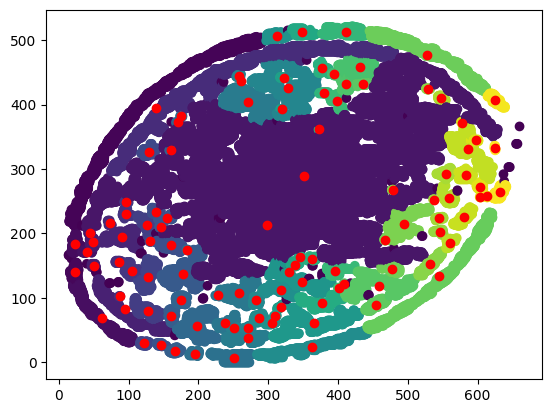

In [41]:
labels = dbscan.fit_predict(points)

plt.scatter(locations[0], locations[1], c=labels)
plt.scatter(centroids.to_numpy()[:,0], centroids.to_numpy()[:,1], c="red")
plt.show()

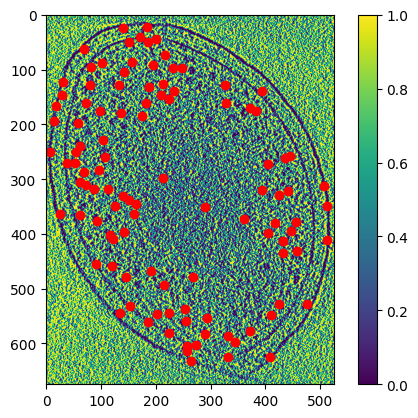

In [42]:
plt.imshow(ten_contrast)
plt.colorbar()
plt.scatter(centroids.to_numpy()[:,1], centroids.to_numpy()[:,0], c="red")
plt.show()

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [44]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

predictor = SamPredictor(sam)

In [45]:
centroids = centroids.to_numpy()
centroids[:,0]
labels = np.ones_like(centroids[:,0])
labels = labels.astype(int)

In [47]:
rgb_bacteria = np.concatenate([bacteria[np.newaxis, ...]] * 3, axis=0)
rgb_bacteria = rgb_bacteria.transpose((1,2,0))
print(rgb_bacteria.shape)

(675, 525, 3)


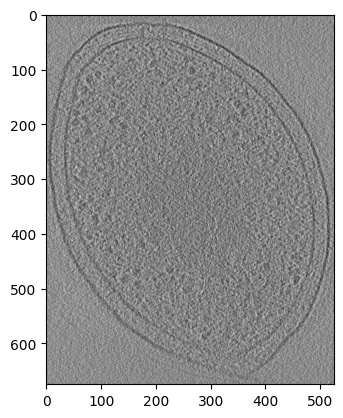

In [48]:
plt.imshow(rgb_bacteria)
plt.show()

In [49]:
predictor.set_image(rgb_bacteria)

In [50]:
masks, scores, logits = predictor.predict(
    point_coords=centroids,
    point_labels=labels,
    multimask_output=True
)

In [171]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

In [52]:
def show_mask(mask, ax, random_color=False):
    if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

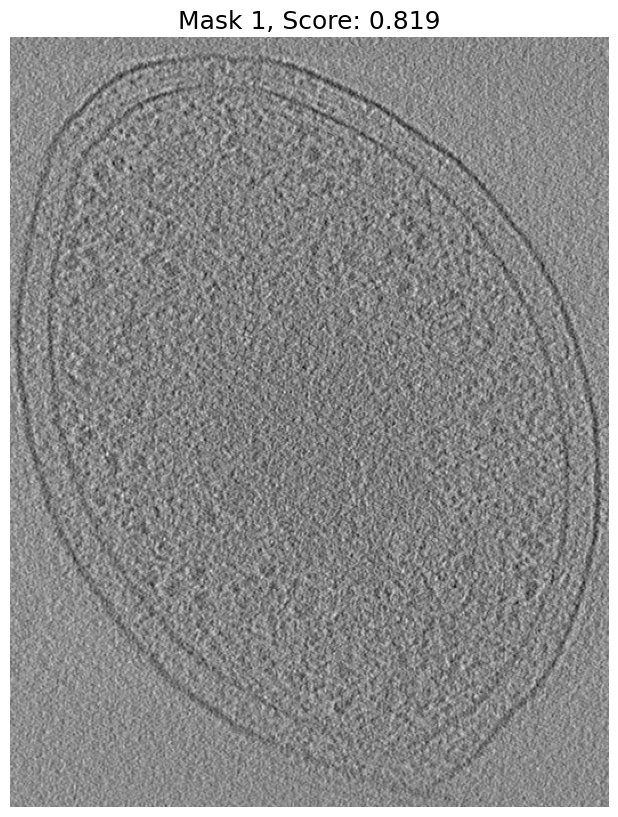

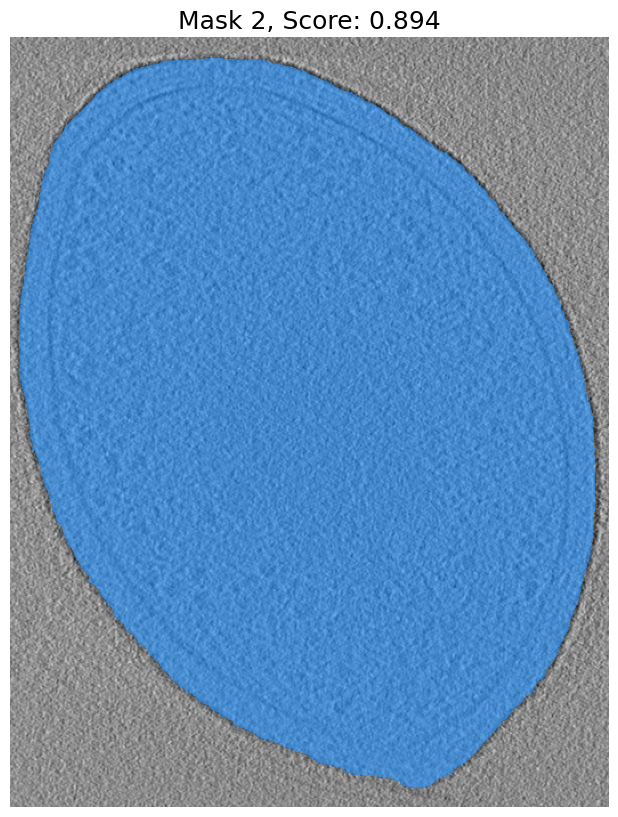

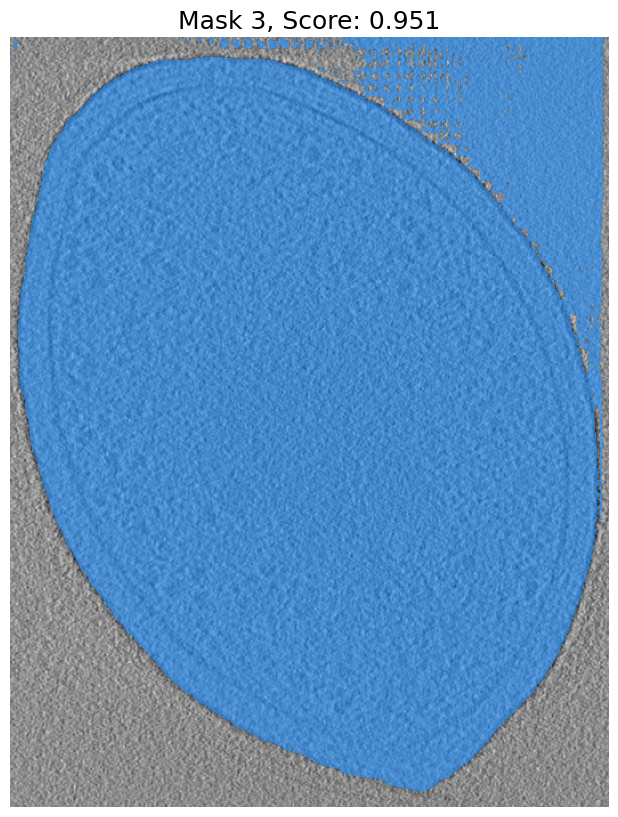

In [54]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(rgb_bacteria)
    show_mask(mask, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [55]:
import pandas as pd

In [56]:
def contrast(image, factor):
    mean = np.mean(image, axis=(0,1), keepdims=True)
    image_contrast = mean + factor * (image - mean)
    image_contrast = np.clip(image_contrast, 0.0, 1.0)
    return image_contrast

In [57]:
def threshold_lt(
        image,
        threshold_factor: float,
    ):
    thresholded_pixels = image < threshold_factor
    mask = np.zeros_like(image)
    mask[thresholded_pixels] = 1
    return mask

In [58]:
def  threshold_gt(
        image,
        threshold_factor: float,
    ):
    thresholded_pixels = image > threshold_factor
    mask = np.zeros_like(image)
    mask[thresholded_pixels] = 1
    return mask

In [182]:
test_array = None

In [245]:
def segment_bacteria(
        bacteria_slice,
        contrast_factor: int=10,
        threshold_factor: float=0.1,
        dbscan_epsilon: float=5,
        display_graphs: bool=True,
    ):
    # Create initial mask
    contrasted_bacteria = contrast(bacteria_slice, contrast_factor)
    bacteria_mask = threshold_lt(contrasted_bacteria, threshold_factor)

    blurred_bacteria = cv2.

    if display_graphs:
        plt.imshow(bacteria_mask)
        plt.show()
    
    # Create filtered mask
    initial_detection = bacteria_mask.copy()
    blurred_mask = cv2.blur(initial_detection,(15,15))
    second_bacteria_mask = threshold_gt(blurred_mask, np.percentile(blurred_mask, 95))

    if display_graphs:
        plt.imshow(second_bacteria_mask)
        plt.show()

    # Cluster filtered mask to get clustered centroids
    initial_points = np.where(second_bacteria_mask == 1)
    points = np.asarray(list(zip(initial_points[0], initial_points[1])))
    dbscan = DBSCAN(
        eps=dbscan_epsilon,
        min_samples=20
    )
    
    labels = dbscan.fit_predict(points)
    point_classes = np.concatenate([np.array(initial_points), labels.reshape(1,-1)]).transpose(1,0)
    global test_array 
    test_array = point_classes.copy()

    df = pd.DataFrame(point_classes, columns=["x_coord", "y_coord", "labels"])
    centroids = df.groupby("labels").mean()
    centroids.drop(-1, axis=0)

    # Display Centroids
    if display_graphs:
        x,y = zip(*points)
        plt.scatter(x, y, c=labels)
        plt.scatter(centroids.to_numpy()[:,0], centroids.to_numpy()[:,1], c="red")
        plt.show()

    # Cluster filtered mask to get clustered centroids
    dbscan_two = DBSCAN(
        eps=200,
        min_samples=20
    )

    centroids = centroids.to_numpy()
    labels = dbscan_two.fit_predict(centroids)
    cx, cy = zip(*centroids)

    if display_graphs:
        plt.imshow(bacteria_slice)
        plt.scatter(
            cy,
            cx,
            c=labels
        )
        plt.legend()
        plt.show()

    counts = {str(label): [] for label in set(labels)}
    for i in range(len(labels)):
        label = str(labels[i])
        counts[label].append(centroids[i][::-1])


    max_count = -1
    max_key = 0
    for key, value in counts.items():
        if len(value) > max_count:
            max_key = key
            max_count = len(value)
    
    predicted_bacteria_locations = np.array(counts[max_key])

    # Format data to be usable by sam
    labels = np.ones_like(predicted_bacteria_locations[:,0]).astype(int)
    rgb_bacteria = np.concatenate([bacteria_slice[np.newaxis, ...]] * 3, axis=0).transpose((1,2,0))
    
    # Set images
    predictor.set_image(rgb_bacteria)
    masks, scores, logits = predictor.predict(
        point_coords=predicted_bacteria_locations,
        point_labels=labels,
        multimask_output=True
    )

    best_score = 0
    selected_mask = None
    for mask, score in zip(masks, scores):
        if score > best_score:
            best_score = score
            selected_mask = mask

    return points, selected_mask, best_score


In [246]:
points, mask, confidence_score = segment_bacteria(
    rescaled,
    threshold_factor=0.001,
    display_graphs=False
)

In [242]:
master_mask = mask.copy()

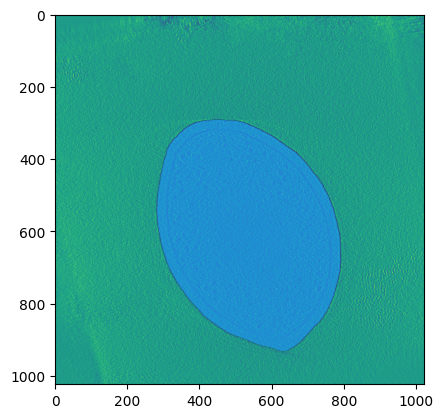

In [247]:
plt.imshow(rescaled)
show_mask(mask, plt.gca())